In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
class HashFamily():
    """Universal hash family
    Args:
        bins (int): Number of bins to hash to. Better if a prime number.
        moduler (int,optional): Temporary hashing. Has to be a prime number.
    """
    def __init__(self, bins, moduler=None):
        if moduler and moduler <= bins:
            raise ValueError("p (moduler) should be >> m (buckets)")

        self.bins = bins
        self.moduler = moduler if moduler else self._next_prime(np.random.randint(self.bins + 1, 2**32))

        # do not allow same a and b, as it could mean shifted hashes
        self.sampled_a = set()
        self.sampled_b = set()

    def _is_prime(self, x):
        """Naive is prime test."""
        for i in range(2, int(np.sqrt(x))):
            if x % i == 0:
                return False
        return True

    def _next_prime(self, n):
        """Naively gets the next prime larger than n."""
        while not self._is_prime(n):
            n += 1

        return n

    def draw_hash(self, a=None, b=None):
        """Draws a single hash function from the family."""
        if a is None:
            while a is None or a in self.sampled_a:
                a = np.random.randint(1, self.moduler - 1)
                assert len(self.sampled_a) < self.moduler - 2, "please give a bigger moduler"

            self.sampled_a.add(a)
        if b is None:
            while b is None or b in self.sampled_b:
                b = np.random.randint(0, self.moduler - 1)
                assert len(self.sampled_b) < self.moduler - 1, "please give a bigger moduler"

            self.sampled_b.add(b)

        return lambda x: ((a * x + b) % self.moduler) % self.bins

    def draw_hashes(self, n, **kwargs):
        """Draws n hash function from the family."""
        return [self.draw_hash() for i in range(n)]

In [3]:
def power2(color):
    return 2**(color)

def dp_helper(dp_mat, cur_color, G, colors, k, khop_set, start_node, subgraph='path'):
    new_khop_set = set()
    if len(khop_set)==0:
        return []
    for col in range(dp_mat.shape[1]):
#         find the correct columns representing current number of color
        if bin(col).count("1")!=cur_color-1:
            continue
        for v in khop_set:
            if dp_mat[v][col]>0:
                for neighbor in G[v]:
                    aggregate_color = (power2(colors[neighbor])|col)
                    if bin(aggregate_color).count("1")==cur_color:
                        new_khop_set.add(neighbor)
                        dp_mat[neighbor][aggregate_color] = 1
    if cur_color==k:
        if subgraph=='path':
            return np.where(dp_mat[:,-1]==1)[0]
        elif subgraph=='cycle':
            return set(np.where(dp_mat[:,-1]==1)[0]) & set(G[start_node])
    return dp_helper(dp_mat, cur_color+1, G, colors, k, new_khop_set, start_node, subgraph)
        
def backtrack(dp_mat, G, colors, target, s, prev_path, prev_colors, verbose):
    if target==s:
        if verbose:
            print(prev_path)
        global_path.add(','.join(prev_path))
        prev_path.pop()
        return 1
    count = 0
    for neigh in G[target]:
        not_visited = dp_mat.shape[1]-1^prev_colors
        if is_set(prev_colors, colors[neigh]):
            continue
        if dp_mat[neigh][not_visited]>0:
            count += backtrack(dp_mat, G, colors, neigh, s, prev_path+[str(neigh)], set_bit(prev_colors, colors[neigh]), verbose)
    prev_path.pop()
    return count
    
def colorful_subgraph(G, colors, k, s, subgraph_type, get_detail=True, verbose=False):
    """Detect if colorful path exists fom s to any node by dynamic programming.
    Args:
        G (nx.Graph): with n nodes and m edges
        colors (list): list of integers represents node colors
        k (int): number of colors 
        s (int): starting node
        subgraph (str): 'path' or 'cycle'
    Return:
        List: nodes connect to s with at least one colorful path
    """
    n = G.number_of_nodes()
    col = 2**k
    dp_mat = np.zeros((n, col))
    dp_mat[s][power2(colors[s])] = 1
    targets = dp_helper(dp_mat, 2, G, colors, k, set([s]), s, subgraph_type)
    if not get_detail:
        return targets
    else:
        empty_color = 0
        total_count = 0
        for target in targets:
            total_count += backtrack(dp_mat, G, colors, target, s, [str(target)], set_bit(empty_color, colors[target]), verbose)
        if verbose:
            print('from node', s, 'find in total', total_count, 'colorful paths of length', k)
        return total_count

def color_by_hashes(G, k, repeat, modulor=None):
    hashes = HashFamily(k, modulor)
    hash_list = hashes.draw_hashes(repeat)
    color_list = []
    for hashF in hash_list:
        color_list.append([hashF(i) for i in G.nodes])
    return color_list

In [4]:
def colorful_cycle(G, colors, k, s):
    n = G.number_of_nodes()
    col = 2**k
    dp_mat = np.zeros((n, col))
    dp_mat[s][power2(colors[s])] = 1
    return dp_helper(dp_mat, 2, G, colors, k, set([s]), s, 'cycle')

In [30]:
def is_set(x, n):
    '''
    Check if bit n of integer x is set.
    '''
    return x & 1 << n != 0

def set_bit(x, n):
    return x | (1<<n)


def backtrack(dp_mat, G, colors, target, s, prev_path, prev_colors, verbose):
    if target==s:
        if verbose:
            print(prev_path)
        global_path.add(','.join(prev_path))
        prev_path.pop()
        return 1
    count = 0
    for neigh in G[target]:
        not_visited = dp_mat.shape[1]-1^prev_colors
        if is_set(prev_colors, colors[neigh]):
            continue
        if dp_mat[neigh][not_visited]>0:
            count += backtrack(dp_mat, G, colors, neigh, s, prev_path+[str(neigh)], set_bit(prev_colors, colors[neigh]), verbose)
    prev_path.pop()
    return count
     
def find_subgraph(G, k, subgraph, color_repeat, get_detail=True, verbose=False, plot=True):
    count = 0 
    global global_path
    global_path = set()
    
    repeat = math.ceil(math.exp(k))
    colors = color_by_hashes(G, k, repeat, modulor=97)
    for color in colors:
        if plot:
            nx.draw(G, node_color=color, with_labels=True)
            plt.show()
        for i in G.nodes():
            tmp_res = colorful_subgraph(G, color, k, i, subgraph, get_detail, verbose)
    #         print(i, tmp_res)
        count += 1
        if count >= color_repeat:
            break
    print('set of', subgraph, 'found:', global_path)

In [6]:
# Demo for correctness
G = nx.erdos_renyi_graph(10, 0.2)


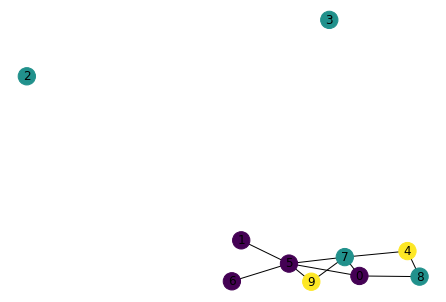

set of path found: {'5,7,4', '9,7,0', '5,9,7', '7,5,9', '0,7,4', '0,7,9', '4,7,0', '4,7,5', '9,5,7', '9,7,5', '7,9,5', '4,8,0', '5,7,9', '0,8,4'}


In [31]:

find_subgraph(G, 3, 'path', 1, get_detail=True, verbose=False, plot=True)

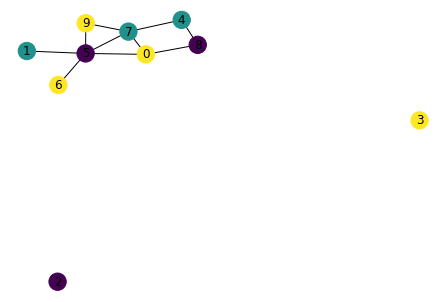

set of cycle found: {'7,5,0', '0,5,7', '5,9,7', '5,7,0', '7,0,5', '7,5,9', '9,5,7', '5,0,7', '9,7,5', '7,9,5', '0,7,5', '5,7,9'}


In [33]:

find_subgraph(G, 3, 'cycle', 1, get_detail=True, verbose=False, plot=True)